In [1]:
import sys
sys.path.append('..')

import utils, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import random
from sklearn.linear_model import LinearRegression, RANSACRegressor

/Users/scrotti/Aptamer2025py/experiments/../indep_sites.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = torch.device("cpu")
dtype = torch.float32
ts = range(len(round_ids))

In [740]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)
reload(sampling)
reload(selex_distribution)
reload(energy_models)

<module 'energy_models' from '/Users/scrotti/Aptamer2025py/experiments/../energy_models.py'>

In [4]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)
n_rounds = len(round_ids)

Extracting sequences...
Finished round ARN
Finished round R01
Finished round R02N


In [52]:
sequences_oh = [one_hot(s) for s in sequences]
total_reads = torch.tensor([len(s) for s in sequences])

In [15]:
# model = torch.load('./saved/Dop8V030.pt', weights_only=False, map_location=torch.device('cpu'))

In [741]:
L, q = 45, 4

tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1],
     [1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

k = torch.randn(L, q, dtype=dtype) * 1e-4
h = torch.randn(L, q, dtype=dtype) * 1e-4

Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.IndepSites(h), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [742]:
models_up_to_t = [energy_models.IndepSites(model.round_zero.h + t * model.selection.modes[0].h) for t in range(n_rounds)]
models_sel_up_to_t = [energy_models.IndepSites(t * model.selection.modes[0].h) for t in range(n_rounds)]
model_ps = energy_models.IndepSites(model.selection.modes[0].h)
logZt_true = torch.tensor([model_t.lognormalization() for model_t in models_up_to_t])
logZt_true

tensor([62.3828, 62.3828, 62.3828])

In [743]:
n_chains = 10**2
n_sweeps = 10
step = 0.01
beta_schedule = torch.arange(step, 1+step, step)

chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
logZt, log_weights_all = sampling.estimate_normalizations(model, chains, n_sweeps, beta_schedule)
logZt

tensor([62.3828, 62.3828, 62.3829])

In [744]:
n_chains = 10**3
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [745]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [746]:
n_sweeps = 30
lr = 0.1
max_epochs = 10

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, 
               callbacks=callbacks, log_weights=log_weights, lr=lr,
               log_multinomial_factors = log_multinomial_factors)

 0.00%[                                    ] Epoch: 0/10 [00:00, ?it/s]

In [747]:
n_chains = 10**3
n_sweeps = 1
step = 0.01
beta_schedule = torch.arange(step, 1+step, step)

chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
logZt, log_weights_all = sampling.estimate_normalizations(model, chains, n_sweeps, beta_schedule)
logZt

tensor([62.3919, 62.4322, 62.5031])

In [748]:
models_t = [energy_models.IndepSites(k + t * h) for t in range(n_rounds)]
logZt_true = torch.tensor([model_t.lognormalization() for model_t in models_t])
logZt_true

tensor([62.3915, 62.4307, 62.5025])

In [749]:
log_n_chains = torch.log(torch.tensor(n_chains, device=device, dtype=dtype)).item()
lZt = torch.zeros(n_rounds)
for t in range(len(chains)):
    lZt[t] = log_weights[t].logsumexp(0) - torch.log(torch.tensor([log_weights[t].size(0)])) + L*torch.log(torch.tensor([q]))
lZt

tensor([62.3917, 62.4310, 62.4917])

In [750]:
batches = [next(iter(dl)) for dl in data_loaders]
- training.estimate_log_likelihood(model, batches, total_reads, log_weights, log_multinomial_factors) 

2.830071142343858

In [43]:
beta_schedule = torch.arange(0, 1, 1e-1)
n_sweeps = 10

In [62]:
def annealed_importance_sampling(model, chains, beta_schedule, n_sweeps):
    n_rounds, n_chains, L, q = chains.size()
    log_weights = torch.zeros(n_rounds, n_chains, dtype=chains.dtype)
    energies = [model.compute_energy_up_to_round(chains[t], t) for t in ts]
    beta_prev = 0.0
    
    for beta in beta_schedule:
        for t in range(len(chains)):
            energies[t] = sampling.sample_metropolis(model, chains, t, n_sweeps, beta)
            log_weights[t] += (beta_prev - beta) * energies[t]

    return log_weights

In [78]:
n_chains_schedule = torch.round(torch.logspace(2, 4, 5)).to(torch.int)
n_chains_schedule

tensor([  100,   316,  1000,  3162, 10000], dtype=torch.int32)

In [80]:
log_weights = []

for n_chains in n_chains_schedule:
    print(f'Starting AIS with {n_chains} chains...')
    chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
    lw = annealed_importance_sampling(model, chains, beta_schedule, n_sweeps)
    log_weights.append(lw)

Starting AIS with 100 chains...
Starting AIS with 316 chains...
Starting AIS with 1000 chains...
Starting AIS with 3162 chains...
Starting AIS with 10000 chains...


In [84]:
logZt = []
for n in range(len(n_chains_schedule)):
    lZt = torch.zeros(n_rounds)
    for t in range(len(chains)):
        log_n_chains = torch.log(torch.tensor(n_chains_schedule[n], device=device, dtype=dtype)).item()
        lZt[t] = Llogq + (torch.logsumexp(log_weights[n][t], dim=0)).item() - log_n_chains
    logZt.append(lZt)
logZt

/var/folders/4z/by73cp452tnbxp2j1gfzz5n80000gq/T/ipykernel_29943/197459017.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_n_chains = torch.log(torch.tensor(n_chains_schedule[n], device=device, dtype=dtype)).item()


[tensor([149.5300, 165.1555, 218.3840]),
 tensor([149.1006, 167.8409, 222.8778]),
 tensor([148.3428, 175.5319, 229.0332]),
 tensor([149.4932, 173.5907, 230.1306]),
 tensor([150.0463, 171.1529, 230.7302])]

In [70]:
models_t = [energy_models.IndepSites(k + t * h) for t in range(n_rounds)]
logZt_true = torch.tensor([model_t.lognormalization().detach().item() for model_t in models_t])
logZt_true

tensor([ 74.3706,  87.7754, 118.7790])

In [65]:
Llogq = L * torch.log(torch.tensor(q, device=device, dtype=dtype)).item()
log_n_chains = torch.log(torch.tensor(n_chains, device=device, dtype=dtype)).item()

logZt = torch.zeros(n_rounds)
for t in range(len(chains)):
    logZt[t] = Llogq + (torch.logsumexp(log_weights[t], dim=0)).item() - log_n_chains
logZt

tensor([149.4765, 165.4501, 219.2819])

In [72]:
logZt / logZt_true

tensor([2.0099, 1.8849, 1.8461])

In [54]:
batches = [next(iter(dl)) for dl in data_loaders]
ll = training.estimate_log_likelihood(model, batches, total_reads, log_weights, log_multinomial_factors)

In [55]:
ll

-2.7383926312092184

In [80]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [81]:
batch_size = 10**4
data_loaders_train = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_train_oh]
data_loaders_test = [data_loading.SelexRoundDataLoader(seq_oh, device=device) for seq_oh in sequences_test_oh]

n_chains = 10**2
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 3000

training.train(model, data_loaders_train, total_reads_train, chains, n_sweeps, max_epochs, target_pearson, lr=lr, 
               callbacks=callbacks, log_weights=log_weights, 
               log_multinomial_factors=logmult_train, log_multinomial_factors_valid=logmult_test,
               data_loaders_valid=data_loaders_test, total_reads_valid=total_reads_test)

 0.00%[                                  ] Epoch: 0/3000 [00:00, ?it/s]

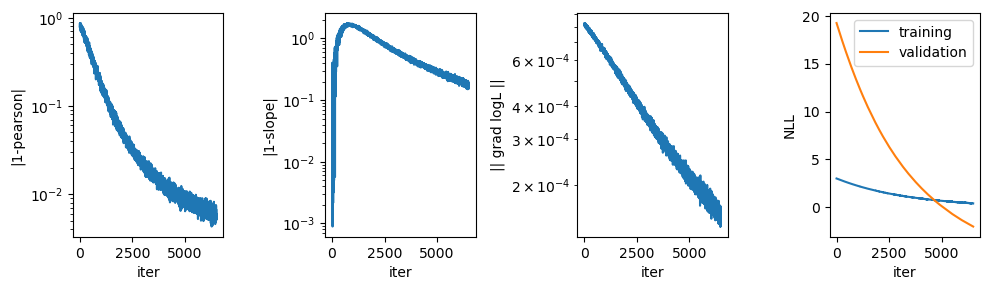

In [89]:
fig, axes = callbacks[0].plot();

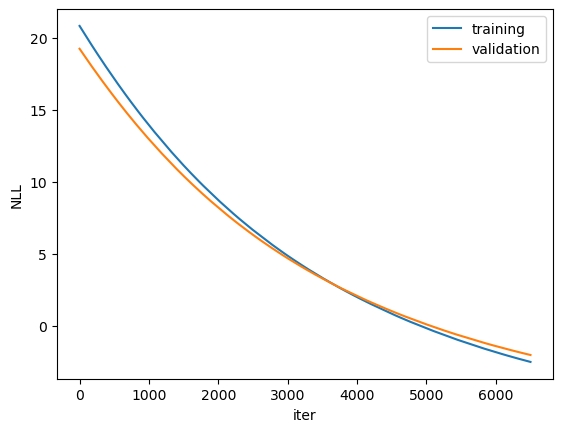

In [90]:
fig, axes = callbacks[2].plot();

## Picking test sequences not among the highest counts

In [ ]:
n_test = 10**4
n_top = None

sequences_train = []
sequences_test = []
sequences_train_top = []
sequences_unique_train = []
sequences_unique_test = []
sequences_unique_train_top = []
counts_train = []
counts_train_top = []
counts_test = []

for t in ts:
    print(f'Starting round {t} of {len(ts)-1}...')
    (sequences_unique_train_t, sequences_unique_test_t, sequences_unique_train_top_t, \
    sequences_train_t, sequences_test_t, sequences_train_top_t, \
    counts_train_t, counts_test_t, counts_train_top_t) = \
        split_train_test(sequences[t], n_test, n_top, sequences_unique[t], counts[t])
    sequences_train.append(sequences_train_t)
    sequences_train_top.append(sequences_train_top_t)
    sequences_test.append(sequences_test_t)
    sequences_unique_train.append(sequences_unique_train_t)
    sequences_unique_train_top.append(sequences_unique_train_top_t)
    sequences_unique_test.append(sequences_unique_test_t)
    counts_train.append(counts_train_t)
    counts_train_top.append(counts_train_top_t)
    counts_test.append(counts_test_t)

In [ ]:
sequences_train_oh = [one_hot(sequences_train[t]).to(dtype=dtype) for t in ts]
sequences_test_oh = [one_hot(sequences_test[t]).to(dtype=dtype) for t in ts]
sequences_unique_train_oh = [one_hot(sequences_unique_train[t]).to(dtype=dtype) for t in ts]
sequences_unique_test_oh = [one_hot(sequences_unique_test[t]).to(dtype=dtype) for t in ts]
sequences_train_top_oh = [one_hot(sequences_train_top[t]).to(dtype=dtype) for t in ts]
sequences_unique_train_top_oh = [one_hot(sequences_unique_train_top[t]).to(dtype=dtype) for t in ts]
logmult_test = torch.tensor([utils.log_multinomial(counts_test[t]) for t in ts])
logmult_train_top = torch.tensor([utils.log_multinomial(counts_train_top[t]) for t in ts])
logmult_train = torch.tensor([utils.log_multinomial(counts_train[t]) for t in ts])
total_reads_train = torch.Tensor([s.shape[0] for s in sequences_train_oh])
total_reads_test = torch.Tensor([s.shape[0] for s in sequences_test_oh])

In [ ]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_train_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
# J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
mode = energy_models.IndepSites(h)

ps = selex_distribution.MultiModeDistribution(mode, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [139]:
logNst_test = [- model.compute_energy_up_to_round(sequences_unique_test_oh[t], t).detach().cpu()
               for t in ts]

In [78]:
def scatter_with_fit(x, y, **kwargs):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(x, y, **kwargs)
    reg = RANSACRegressor().fit(x.reshape(-1, 1), y)
    ax.plot(x, reg.predict(x.reshape(-1,1)), color='r', linewidth=1, label='Robust fit')
    return fig, ax

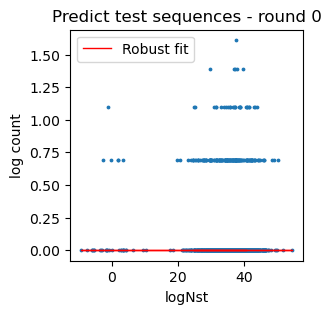

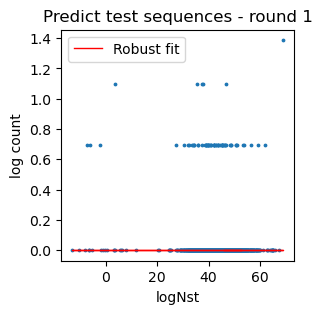

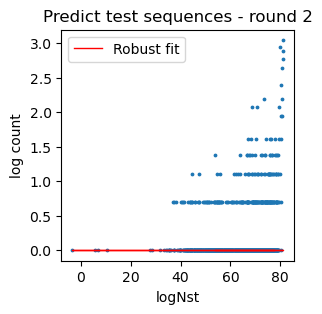

In [79]:
for t in ts:
    fig, ax = scatter_with_fit(logNst_test[t], torch.log(counts_test[t]), s=3)
    ax.set_xlabel('logNst')
    ax.set_ylabel('log count')
    ax.legend()
    ax.set_title(f'Predict test sequences - round {t}')